# 3D Alpha shape method 


In computational geometry, an alpha shape, or α-shape, is a family of piecewise linear simple curves in the Euclidean plane associated with the shape of a finite set of points. They were first defined by Edelsbrunner, Kirkpatrick & Seidel (1983). The alpha-shape associated with a set of points is a generalization of the concept of the convex hull, i.e. every convex hull is an alpha-shape but not every alpha shape is a convex hull.

### Generation of a point cloud

In [32]:
kL = 1
kB = 0.26
kH = 0.025

anz_x = int(2)
anz_y = int(2)
anz_z = int(1)

dis_x = kL/anz_x
dis_y = kB/anz_y
dis_z = kH/anz_z

k = 1
points_list= []
print(anz_x, anz_y, anz_z)
#coor_init = open('coor_init.dat', 'w')  # for feap
for h in range(anz_z + 1):
    for i in range(anz_y + 1):
        for j in range(anz_x + 1):
            points_list.append([j*dis_x, i*dis_y, h*dis_z])
            #coor_init.write(str(k) + '  ' + str(j * dis_x) + '  ' + str(i * dis_y) + '  ' + str(h * dis_z) + '\n')
            k = k + 1

points= np.array(points_list)

2 2 1


### 3D alpha shape method algorithm

In [33]:
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape_3D(pos, alpha):
    """
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """
    # difference of python and matlab 
    # to delete the useless elements for mesh
    N = 3  # The dimensions of our points
    options = 'Qt Qbb Qc' if N <= 3 else 'Qt Qbb Qc Qx'  # Set the QHull options

    tetra = Delaunay(pos, qhull_options=options)
    keep = np.ones(len(tetra.simplices), dtype=bool)
    for i, t in enumerate(tetra.simplices):
        if abs(np.linalg.det(np.hstack((pos[t], np.ones([1, N + 1]).T)))) < 1E-15:
            keep[i] = False  # Point is coplanar, we don't want to keep it
    tetras = tetra.simplices[keep]

    print('Nr.Tet:',len(tetras))

    # Find radius of the circumsphere.
    # By definition, radius of the sphere fitting inside the tetrahedral needs
    # to be smaller than alpha value
    # http://mathworld.wolfram.com/Circumsphere.html
    #### circumradius
    tetrapos = np.take(pos,tetras,axis=0)
    normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
    ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
    a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
    Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
    Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
    Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
    c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
    s = Dx ** 2 + Dy ** 2 + Dz ** 2 - 4 * a * c
    r_circum = np.sqrt(s)/(2*np.abs(a))

    '''Norm = np.empty(len(tetrapos))
    ############# inradius #########################################
    for i, faces in enumerate(tetrapos):
        face_a = faces[0]
        face_b = faces[1]
        face_c = faces[2]
        face_d = faces[3]
        # normal vector of abcd
        Norm_abc = np.linalg.norm(np.cross((face_b-face_a),(face_c-face_a)))
        Norm_bcd = np.linalg.norm(np.cross((face_c-face_b),(face_d-face_b)))
        Norm_cda = np.linalg.norm(np.cross((face_d-face_c),(face_a-face_c)))
        Norm_dab = np.linalg.norm(np.cross((face_a-face_d),(face_b-face_a)))

        Norm_sum = Norm_abc + Norm_bcd + Norm_cda + Norm_dab
        Norm[i]=Norm_sum

    r_in = np.abs(a)/Norm
    r= r_circum/r_in'''
    # Find tetrahedrals
    tetras_alp = tetras[r_circum<alpha,:]

    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras_alp[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)
    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    tet_cell = tetras_alp
    return Vertices,Edges,Triangles,tet_cell


### Call alpha shape

In [34]:
alpha = 0.5
vertices, Edges,Triangles, tet_cell=alpha_shape_3D(points, alpha)

Nr.Tet: 24


### Plot tetrahedrons

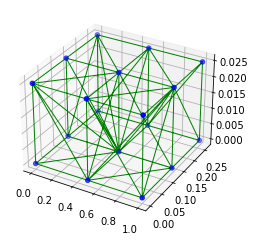

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

def collect_edges(tri):
    edges = set()

    def sorted_tuple(a, b):
        return (a, b) if a < b else (b, a)

        # Add edges of tetrahedron (sorted so we don't add an edge twice, even if it comes in reverse order).
    for (i0, i1, i2, i3) in tet_cell:#tri.simplices:
        edges.add(sorted_tuple(i0, i1))
        edges.add(sorted_tuple(i0, i2))
        edges.add(sorted_tuple(i0, i3))
        edges.add(sorted_tuple(i1, i2))
        edges.add(sorted_tuple(i1, i3))
        edges.add(sorted_tuple(i2, i3))
    return edges


def plot_tri_2(ax, points, tri):
    edges = collect_edges(tri)
    x = np.array([])
    y = np.array([])
    z = np.array([])
    for (i, j) in edges:
        x = np.append(x, [points[i, 0], points[j, 0], np.nan])
        y = np.append(y, [points[i, 1], points[j, 1], np.nan])
        z = np.append(z, [points[i, 2], points[j, 2], np.nan])

    ax.plot3D(x, y, z, color='g', lw='1')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b')

plot_tri_2(ax, points, tet_cell)
plt.show()